In [111]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Genetic approach to artificial intelligence in gaming

## Introduction

In this training, I want to focus on the algorithm and not on its performance, this will be for a later study-case.

Artificial intelligence has always been present in games, so the player can play even alone.
Finding some complex problems to solve shouldn't be a hard task.

Let's take a real game and try to make an artificial intelligence which solves the game.
I choosed a french TV game "Le compte est bon". Let's explains the rules:

 * a goal number is randomly choosen between 100 and 999
 * 6 numbers are randomly choosen from the set : ``[1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 25, 50, 75, 100]``
 * with only the basic integer operations ``+ - * /`` and the 6 numbers, you have to find the goal number
 * each of the 6 numbers can only be used once

## Example

 * goal number: ``247``
 * set : ``[3, 5, 7, 100, 25, 1]``
 * solution :

```
3 * 7 = 21
5 * 25 = 125
125 + 21 = 146
146 + 100 = 246
246 + 1 = 247
```
 
We can represent the whole calcul in one line : ``(3 * 7) + (5 * 25) + 100 + 1``

Which can also be represented as a tree :

```
  +
 / \
1   +
   / \
 100  +
     / \
    /   \
   *     *
  / \   / \
 3  7   5  25
```

## Where genetics can help us


### About genetic programming

Genetic programming consists on applying the rules of genetic evolution to our algorithm.

On a random population, we determine which candidate solves the problem the best.
This step is called **evaluation**.

The next step is to select the candidates that will be the parents of the next generation. This step is called **selection**.

We select random parts of both parents DNA to build a new one, and then apply a random mutation so the new candidate is unique.

We repeat this process until we have a new population to evaluate.

The most important part is in the *selection* step. Once we scored each candidate in the *evaluation* step we obviously must select the bests to make sure the next generation is closer to the answer.

But building an elite will prevents DNA diversity and the population could never find the solution.

It is important also to include less good candidate, as they can carry intersting genes to pass.

### Example

Lets say we have randomly generated a set of tree :


```
  *              *           
 / \            / \          
1   -          7   +         
   / \            / \        
 100  +         100  +       
     / \            / \      
    /   \          /   \     
   +     /        -     /    
  / \   / \      / \   / \   
 3  7  25  5    3  25 5   1  
```

Those tree could represent the DNA of our population. Genes would be each operators and links to the leafs.

We can easily select part of each tree to insert into a new one as in *DNA combination*.
Then randomly change an operator or switch leafs as in *random mutation*.

Evaluation would consist on parsing the tree, and get the distance to the goal number : ``abs(goal - tree_result)``.

## The first generation

First, we need to generate the game :

In [112]:
import random

elements = list(range(1, 11)) * 2 + [25, 50, 75, 100]
game = random.sample(elements, 6)
goal = random.randint(100, 999)

print goal, ':', game

875 : [100, 3, 6, 7, 9, 2]


Now, we need to generate our population, this means for each candidate we will generate random DNA :

In [113]:
# the DNA is just the calcul in a string
def random_dna(game):
    # we want random links to node, so we need to shuffle the game
    game_shuffled = list(game)
    random.shuffle(game_shuffled)
    
    # let start with an empty dna
    dna = ''

    i = 0
    while i < len(game_shuffled):
        try_dna = dna

        if i > 0:
            try_dna += random.choice([' * ', ' / ', ' + ', ' - '])
        
        try_dna += str(float(game_shuffled[i]))
        
        # we check that the result is still an int before recording the random gene
        check_result = eval(try_dna)

        if check_result == int(check_result):
            dna = try_dna
            i += 1
    
    return dna
    
test_dna = random_dna(game)
test_res = eval(test_dna)

assert test_res == int(test_res)

population_size = 1000
population = [random_dna(game) for _ in range(population_size)]

In [114]:
print 'Test:', test_dna, '=', test_res
print 'Population Size:', population_size
print 'Population:'

for adn in population[:5]:
    print '->', adn, ' = ', eval(adn)

print '-> ...'


for adn in population[-5:]:
    print '->', adn, ' = ', eval(adn)

Test: 9.0 - 100.0 - 6.0 / 2.0 * 7.0 / 3.0 = -98.0
Population Size: 1000
Population:
-> 2.0 - 3.0 - 9.0 - 6.0 + 7.0 + 100.0  =  91.0
-> 7.0 - 6.0 * 2.0 * 100.0 * 3.0 / 9.0  =  -393.0
-> 7.0 - 100.0 + 3.0 * 2.0 / 6.0 + 9.0  =  -83.0
-> 2.0 * 6.0 - 7.0 * 3.0 + 9.0 * 100.0  =  891.0
-> 100.0 + 7.0 + 9.0 + 3.0 * 2.0 + 6.0  =  128.0
-> ...
-> 100.0 + 9.0 * 7.0 + 6.0 + 3.0 - 2.0  =  170.0
-> 6.0 * 2.0 + 9.0 + 100.0 * 7.0 - 3.0  =  718.0
-> 2.0 * 100.0 - 3.0 + 7.0 - 9.0 - 6.0  =  189.0
-> 6.0 - 3.0 - 100.0 + 9.0 * 2.0 - 7.0  =  -86.0
-> 3.0 + 100.0 + 9.0 - 6.0 + 7.0 + 2.0  =  115.0


Now, we would like to score our population :

In [115]:
def score(adn):
    return abs(goal - eval(adn))

scored_population = sorted([(adn, score(adn)) for adn in population], key=lambda item: item[1])

In [123]:
def show_scored_population(scored_population):
    for adn, score in scored_population[:5]:
        print '->', adn, ' = ', eval(adn), '\t|', score

    print '-> ...'

    for adn, score in scored_population[-5:]:
        print '->', adn, ' = ', eval(adn), '\t|', score

show_scored_population(scored_population)

-> 6.0 + 100.0 * 9.0 - 3.0 * 7.0 * 2.0  =  864.0 	| 11.0
-> 2.0 + 3.0 - 7.0 * 6.0 + 9.0 * 100.0  =  863.0 	| 12.0
-> 100.0 * 9.0 - 7.0 * 6.0 + 2.0 + 3.0  =  863.0 	| 12.0
-> 2.0 * 6.0 - 7.0 * 3.0 + 9.0 * 100.0  =  891.0 	| 16.0
-> 3.0 + 6.0 * 7.0 * 9.0 * 2.0 + 100.0  =  859.0 	| 16.0
-> ...
-> 3.0 + 9.0 * 100.0 * 7.0 * 2.0 * 6.0  =  75603.0 	| 74728.0
-> 3.0 * 7.0 * 9.0 * 6.0 * 100.0 - 2.0  =  113398.0 	| 112523.0
-> 7.0 * 9.0 * 100.0 * 3.0 * 6.0 + 2.0  =  113402.0 	| 112527.0
-> 7.0 * 2.0 * 6.0 * 9.0 * 100.0 * 3.0  =  226800.0 	| 225925.0
-> 3.0 * 7.0 * 100.0 * 2.0 * 6.0 * 9.0  =  226800.0 	| 225925.0


If we are lucky, we have found the solution on the first generation. But it is unlikely on more complex problems.

For the fun lets make some stats of the generation:

In [124]:
from collections import OrderedDict
import math
import json


def generation_stats(generation):
    scores = [c[1] for c in generation]
    
    stats = OrderedDict((
        ('avg', float(sum(scores)) / len(scores)),
        ('min', min(scores)),
        ('max', max(scores)),
        ('stdev', None),
        ('q1', None),
        ('med', None),
        ('q3', None)
    ))
    
    variance = float(sum([(s - stats['avg'])**2 for s in scores])) / len(scores)
    stats['stdev'] = math.sqrt(variance)
    
    q1idx = len(scores) / 4
    stats['q1'] = scores[q1idx]
    
    q3idx = 3 * len(scores) / 4
    stats['q3'] = scores[q3idx]
    
    if len(scores) % 2 == 0:
        i1idx = len(scores) / 2
        i2idx = i1idx + 1
        
        i1, i2 = scores[i1idx], scores[i2idx]
        stats['med'] = (i1 + i2) / 2
    
    else:
        medidx = len(scores) / 2 + 1
        stats['med'] = scores[medidx]

    return stats, scores

In [125]:
def plot_stats(stats, scores):
    rows = zip(*stats.items())
    dim = [0.05, 0.80, 0.9, 0.15]

    # Figure 1: min avg/q3 max color graph
    fig1 = plt.figure(figsize=(18, 3))
    a1x = fig1.add_axes(dim)

    cmap1 = matplotlib.colors.ListedColormap(['g', 'b', 'r'])
    bounds1 = [
        stats['min'],
        min(stats['q3'], stats['avg']),
        max(stats['q3'], stats['avg']),
        stats['max']
    ]
    norm1 = matplotlib.colors.BoundaryNorm(bounds1, cmap1.N)
    cbl1 = matplotlib.colorbar.ColorbarBase(
        a1x,
        cmap=cmap1, norm=norm1,
        spacing='proportional',
        orientation='horizontal'
    )

    # Figure 2: min q1 med q3 color graph
    fig2 = plt.figure(figsize=(18, 3))
    a2x = fig2.add_axes(dim)

    cmap2 = matplotlib.colors.ListedColormap(['g', 'b', 'y'])
    bounds2 = [stats['min'], stats['q1'], stats['med'], stats['q3']]
    norm2 = matplotlib.colors.BoundaryNorm(bounds2, cmap2.N)
    cbl2 = matplotlib.colorbar.ColorbarBase(
        a2x,
        cmap=cmap2, norm=norm2,
        spacing='proportional',
        orientation='horizontal'
    )

    a1x.set_xticklabels([
        'min',
        'avg' if stats['avg'] <= stats['q3'] else 'q3',
        'avg' if stats['avg'] > stats['q3'] else 'q3',
        'max'
    ])
    a2x.set_xticklabels(['min', 'q1', 'med', 'q3', 'max'])

    # Figure 3: scores line chart
    fig3, a3x = plt.subplots()
    a3x.plot(scores)
    a3x.grid(True)
    a3x.set_ylabel('Score')
    a3x.set_xlabel('Candidate')

    plt.show()

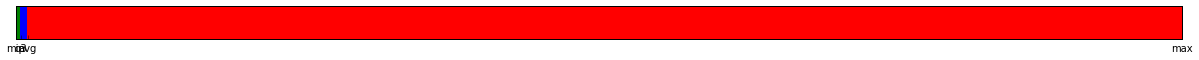

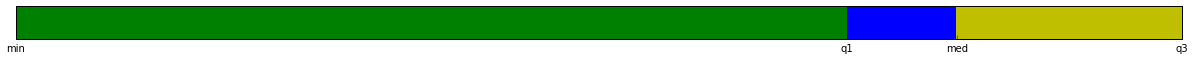

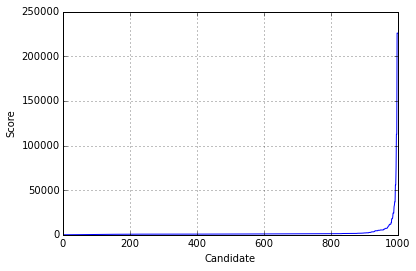

In [126]:
stats1, scores1 = generation_stats(scored_population)
plot_stats(stats1, scores1)

Now that we have our first generation and we know what it looks like, we can proceed to selection.

## Selection implementation

If we just generate a new random population, our algorithm would be nothing else than a bruteforce.

The selection step makes everything. So how do we proceed ?

After a few runs, it looks like the distance from the goal grows slowly except a very few number of with an enormous distance due to random.

This is good! This means we have a lot of interesting solutions.
Let's try the following approach for selection : the 50% best candidates of each quartile in this generation.

In [127]:
def selection(generation, stats):
    parents = []
    
    q1 = filter(lambda c: c[1] < stats['q1'], generation)
    q2 = filter(lambda c: stats['q1'] <= c[1] < stats['med'], generation)
    q3 = filter(lambda c: stats['med'] <= c[1] < stats['q3'], generation)
    q4 = filter(lambda c: stats['q3'] <= c[1], generation)
    
    for q in [q1, q2, q3, q4]:
        parents += q[:len(q) / 2]
    
    return parents

In [128]:
s1 = selection(scored_population, stats1)
show_scored_population(s1)

-> 6.0 + 100.0 * 9.0 - 3.0 * 7.0 * 2.0  =  864.0 	| 11.0
-> 2.0 + 3.0 - 7.0 * 6.0 + 9.0 * 100.0  =  863.0 	| 12.0
-> 100.0 * 9.0 - 7.0 * 6.0 + 2.0 + 3.0  =  863.0 	| 12.0
-> 2.0 * 6.0 - 7.0 * 3.0 + 9.0 * 100.0  =  891.0 	| 16.0
-> 3.0 + 6.0 * 7.0 * 9.0 * 2.0 + 100.0  =  859.0 	| 16.0
-> ...
-> 6.0 + 9.0 - 3.0 - 2.0 - 100.0 * 7.0  =  -690.0 	| 1565.0
-> 9.0 + 2.0 * 3.0 / 6.0 - 100.0 * 7.0  =  -690.0 	| 1565.0
-> 9.0 - 3.0 * 2.0 + 6.0 - 100.0 * 7.0  =  -691.0 	| 1566.0
-> 9.0 - 100.0 * 2.0 * 3.0 * 7.0 / 6.0  =  -691.0 	| 1566.0
-> 3.0 + 9.0 + 2.0 - 7.0 * 100.0 - 6.0  =  -692.0 	| 1567.0


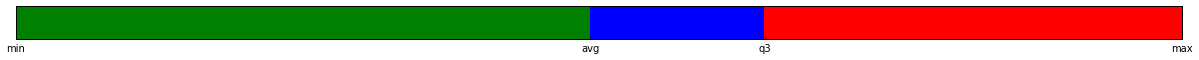

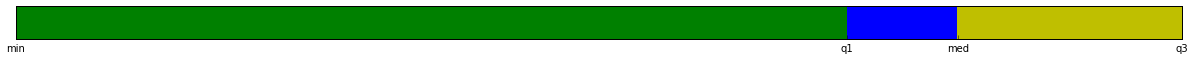

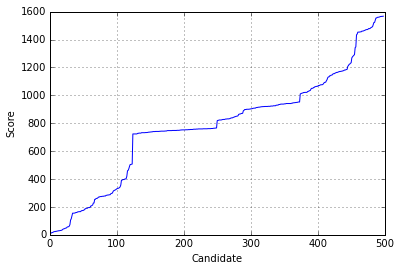

In [129]:
stats_s1, scores_s1 = generation_stats(s1)
plot_stats(stats_s1, scores_s1)

## Combination and mutation, creating the next generation